# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Признаки
**DateCrawled** — дата скачивания анкеты из базы \
**VehicleType** — тип автомобильного кузова\
**RegistrationYear** — год регистрации автомобиля\
**Gearbox** — тип коробки передач\
**Power** — мощность (л. с.)\
**Model** — модель автомобиля\
**Kilometer** — пробег (км)\
**RegistrationMonth** — месяц регистрации автомобиля\
**FuelType** — тип топлива\
**Brand** — марка автомобиля\
**NotRepaired** — была машина в ремонте или нет\
**DateCreated** — дата создания анкеты\
**NumberOfPictures** — количество фотографий автомобиля\
**PostalCode** — почтовый индекс владельца анкеты (пользователя)\
**LastSeen** — дата последней активности пользователя\

### Целевой признак
**Price** — цена (евро)

Для оценки качества моделей необходимо использовать метрику RMSE.

<font color='green'> Значение метрики RMSE должно быть меньше 2500. </font> 

## Подготовка данных

In [2]:
# скачаем требуемые в работе модули

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import xgboost as xgb

import phik
from phik.report import plot_correlation_matrix
from phik import report

import time
import warnings
warnings.filterwarnings('ignore')


In [3]:
#Назначим константу для random_state
RANDOM_STATE = 0

In [4]:
# Создадим датафреймы:
try:
    data = pd.read_csv('autos.csv.')
except:
    data = pd.read_csv('/datasets/autos.csv') # если работа ведется в Яндекс Практикум


In [5]:
# посмотрим содержание полученных данных
print('Общая информация\n')
display(data.info())
print('Первые строки датасета\n')
display(data.head())
print('Описательная статистика\n')
display(data.describe())
print('Описательная статистика категориальных признаков\n')
display(data.describe(include=['object', 'bool']))
print('Количество пропусков в каждом столбце\n')
display(data.isna().sum())
print('Количество уникальных значений\n')
display(data.nunique())
print('Количество дубликатов\n')
display(data.duplicated().sum()) 

Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes:

None

Первые строки датасета



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24-03-16 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24-03-16 00:00,0,70435,07-04-16 03:16
1,24-03-16 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24-03-16 00:00,0,66954,07-04-16 01:46
2,14-03-16 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14-03-16 00:00,0,90480,05-04-16 12:47
3,17-03-16 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17-03-16 00:00,0,91074,17-03-16 17:40
4,31-03-16 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31-03-16 00:00,0,60437,06-04-16 10:17


Описательная статистика



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описательная статистика категориальных признаков



,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05-03-16 14:25,sedan,manual,golf,petrol,volkswagen,no,03-04-16 00:00,07-04-16 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654


Количество пропусков в каждом столбце



DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество уникальных значений



DateCrawled          15470
Price                 3731
VehicleType              8
RegistrationYear       151
Gearbox                  2
Power                  712
Model                  250
Kilometer               13
RegistrationMonth       13
FuelType                 7
Brand                   40
Repaired                 2
DateCreated            109
NumberOfPictures         1
PostalCode            8143
LastSeen             18592
dtype: int64

Количество дубликатов



262

Самая популярная марка модели - Фольксваген, Гольф, с ручной коробкой передач с бензиновым двигателем.

In [6]:
# Посмотрим также уникальные значения в каждом столбце

for column in data.columns:
    print('Уникальные значения столбца', column)
    print(data[column].unique())

Уникальные значения столбца DateCrawled
['24-03-16 11:52' '24-03-16 10:58' '14-03-16 12:52' ... '27-03-16 12:42'
 '08-03-16 00:49' '06-03-16 21:11']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943

### Предварительный вывод о полученных данных

- Всего в таблице 354369 строк и 16 столбцов,
- Пропуски присутствуют в столбцах:
    - VehicleType, тип object, 37490 пропусков
    - Gearbox, тип object, 19833  пропусков
    - Model, тип object, 19705 пропусков
    - FuelType, тип object, 32895 пропусков
    - Repaired, тип object, 71154 пропусков
- Столбец RegistrationYear содержит заведомо ложную информацию, минимальный год равен 1000, максимальный 9999.
- Столбец RegistrationMonth содержит значения от 0 до 12, то есть нули нужно заменить на единицу, так как, возможно, имелся в виду январь.
- Обнаружено четыре явных дубликата.
- Столбец с количеством фотографий (NumberOfPictures) содержит только нули.


In [7]:
# Удалим столбцы, которые не имеют значения для цены, но могут повлиять на работу моделей

processed_data = data[['Price',
                       'VehicleType',
                       'RegistrationYear',
                       'Gearbox',
                       'Power',
                       'Model',
                       'Kilometer',
                       'FuelType',
                       'Brand',
                       'Repaired']]

# Проверим работу кода
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Обработка столбцов

#### Цена

In [8]:
# Проверим значения в столбце Price
processed_data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64

10772 автомобиля имеют нулевую стоимость. Эти значения могут влиять на работу модели, заменим нули на медианное значение.

In [9]:
# Вычислим медианное значение по столбцу Price
avg = processed_data['Price'].median()
# Заменим нули на медианное значение
processed_data['Price'] = processed_data['Price'].apply(lambda v: avg if v==0 else v)
# Округлим полученное значение до целого цисла путем изменения формата данных
processed_data['Price'] = processed_data['Price'].astype(int)
# Проверим работу кода
processed_data['Price'].value_counts()

2700     12299
500       5670
1500      5394
1000      4649
1200      4594
         ...  
7435         1
16845        1
17159        1
7396         1
10985        1
Name: Price, Length: 3730, dtype: int64

<AxesSubplot: >

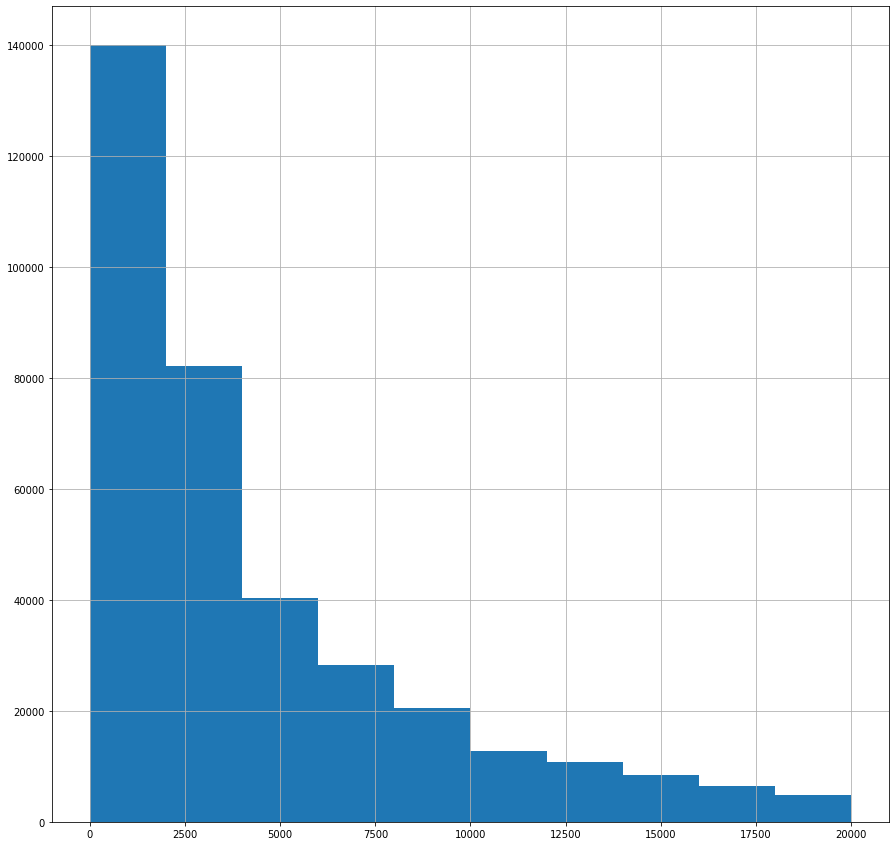

In [10]:
# Проверим распределение цены на гистограмме
processed_data['Price'].hist(figsize=(15, 15))

Большинство моделей стоят до 2500 уе. Средняя цена примерно от 3500 до 6500 уе.

#### Тип кузова

In [11]:
processed_data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [12]:
processed_data[processed_data['VehicleType'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN
...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,NaN,mercedes_benz,NaN
354351,1900,NaN,2000,manual,110,NaN,150000,NaN,volkswagen,no
354361,5250,NaN,2016,auto,150,159,150000,NaN,alfa_romeo,no
354364,2700,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes


37490 пропусков в колонке с типом кузова. Замену пропусков в категориальных значениях будем делать при помощи моды как самого часто встречающегося значения.

In [13]:
# Заменим пропуски в типе кузова на седан.
processed_data['VehicleType'] = processed_data['VehicleType'].fillna('sedan')
# Проверим работу кода
processed_data['VehicleType'].isna().sum()
# изменим тип other на other0 чтобы избежать ошибки в последующем
processed_data = processed_data.replace({'VehicleType':{'other' : 'other0'}})


#### Год регистрации автомобиля

In [14]:
processed_data['RegistrationYear'].value_counts()

2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: RegistrationYear, Length: 151, dtype: int64

In [15]:
processed_data['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot: >

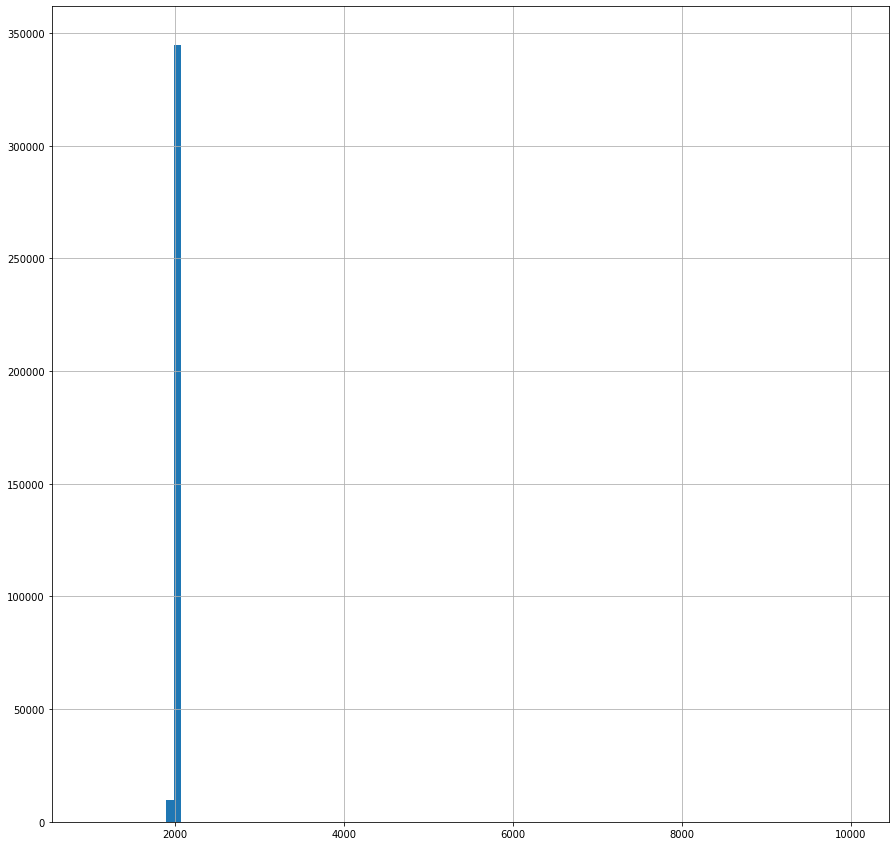

In [16]:
processed_data['RegistrationYear'].hist(bins = 100, figsize=(15, 15))

Очень много "грязных" данных, необходимо будет убрать выбросы.

In [17]:
# Посмотрим на даты регистрации на сайте из первоначальных данных
data['DateCreated'].sort_values()

282006    01-02-16 00:00
293917    01-02-16 00:00
247299    01-02-16 00:00
113941    01-03-16 00:00
165104    01-03-16 00:00
               ...      
184582    31-03-16 00:00
30658     31-03-16 00:00
277149    31-03-16 00:00
30637     31-03-16 00:00
290008    31-03-16 00:00
Name: DateCreated, Length: 354369, dtype: object

В нашем дата сете последняя дата регистрации - 7 апреля 2016-года, клиент не мог продавать машину из будущего. То есть верхний порог - 2016-ый год. Уберем все значения, которые выше этого порога. Нижний порог установим в районе 50-го года, так как в последние годы стали популярны послевоенные машины для реставрации и последующей перепродажи.

In [18]:
# Уберем значения ниже 1960-го года и выше 2016-го
processed_data = processed_data.query('1950 < RegistrationYear < 2017')
# Проверим работу кода
processed_data['RegistrationYear'].describe()


count    339575.000000
mean       2002.527963
std           6.825243
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

<AxesSubplot: >

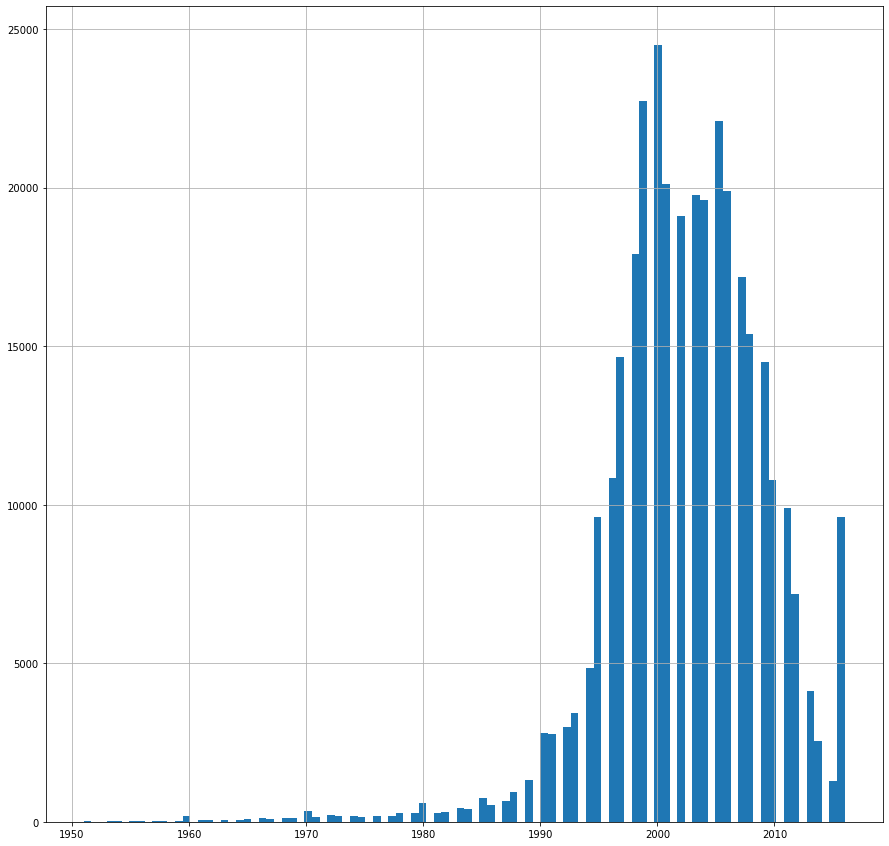

In [19]:
processed_data['RegistrationYear'].hist(bins = 100, figsize=(15, 15))


Как видно на графике, послевоенных машин нет совсем, а самые популярные года выпуска для перепродажи примерно от 1996 до 2012 (по данным таблицы, в которой значения указаны для 2016-го года).

#### Тип коробки передач

In [20]:
processed_data['Gearbox'].value_counts()

manual    257468
auto       64296
Name: Gearbox, dtype: int64

In [21]:
display(processed_data['Gearbox'].describe())
display(processed_data[processed_data['Gearbox'].isna()])

count     321764
unique         2
top       manual
freq      257468
Name: Gearbox, dtype: object

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
16,300,sedan,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,sedan,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,2700,sedan,1990,NaN,0,corsa,150000,petrol,opel,NaN
69,1200,coupe,2001,NaN,0,astra,150000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354288,3300,wagon,2006,NaN,0,touran,150000,gasoline,volkswagen,NaN
354305,3500,sedan,1995,NaN,0,polo,150000,NaN,volkswagen,NaN
354329,350,small,1996,NaN,65,punto,150000,NaN,fiat,NaN
354338,180,sedan,1995,NaN,0,NaN,125000,petrol,opel,NaN


Количество автомобилей с механической (ручной) коробкой передач больше почти в четыре раза чем с автоматической. И при этом, у нас 17664 пропусков. Заменим их все на механический тип коробки.

In [22]:
# Заменим пропуски в типе кузова на седан.
processed_data['Gearbox'] = processed_data['Gearbox'].fillna('manual')
# Проверим работу кода
processed_data['Gearbox'].isna().sum()

0

#### Мощность двигателя в л.с.

In [23]:
processed_data['Power'].value_counts()

0       36315
75      22806
60      15166
150     14149
101     12732
        ...  
1054        1
851         1
1339        1
1659        1
1241        1
Name: Power, Length: 699, dtype: int64

In [24]:
processed_data['Power'].describe()

count    339575.00000
mean        111.04993
std         186.90360
min           0.00000
25%          69.00000
50%         105.00000
75%         143.00000
max       20000.00000
Name: Power, dtype: float64

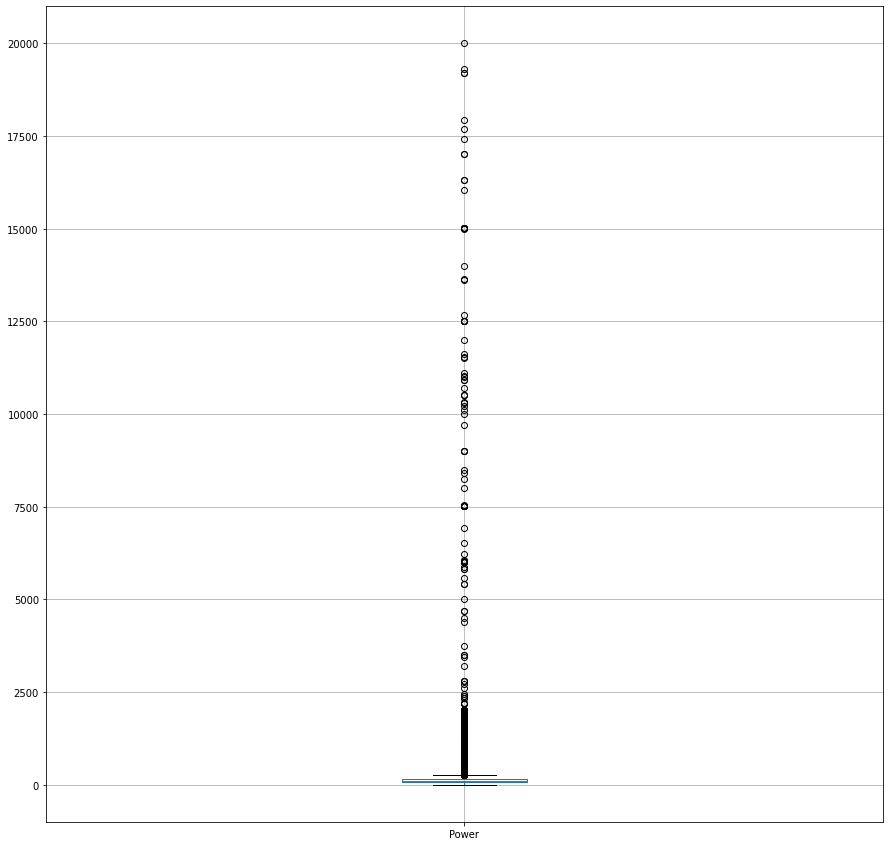

In [25]:
processed_data.boxplot(column='Power', figsize=(15, 15))
plt.show()

20000 лошадиных сил - кажется, что кто-то пытается продать огромный контейнеровоз на площадке для продажи автомобилей. Но у нас есть 36137 автомобилей совсем без лошадиных сил, равных нулю.

На данный момент самый мощный автомобиль Porsche 9FF F97 A-Max с 1400 лошадиных сил под капотом. Установим это значение для самого высокого порога.

In [26]:
processed_data = processed_data.query('Power < 1400')


Для нулевых значений также укажем медианное значение для мощности двигателя.

In [27]:
# Вычислим медианное значение по столбцу Price
avg = processed_data['Power'].median()
# Заменим нули на медианное значение
processed_data['Power'] = processed_data['Power'].apply(lambda v: avg if v==0 else v)
# Округлим полученное значение до целого цисла путем изменения формата данных
processed_data['Power'] = processed_data['Power'].astype(int)
# Проверим работу кода
processed_data['Power'].value_counts()

105     46272
75      22806
60      15166
150     14149
101     12732
        ...  
960         1
489         1
428         1
1164        1
1241        1
Name: Power, Length: 541, dtype: int64

<AxesSubplot: >

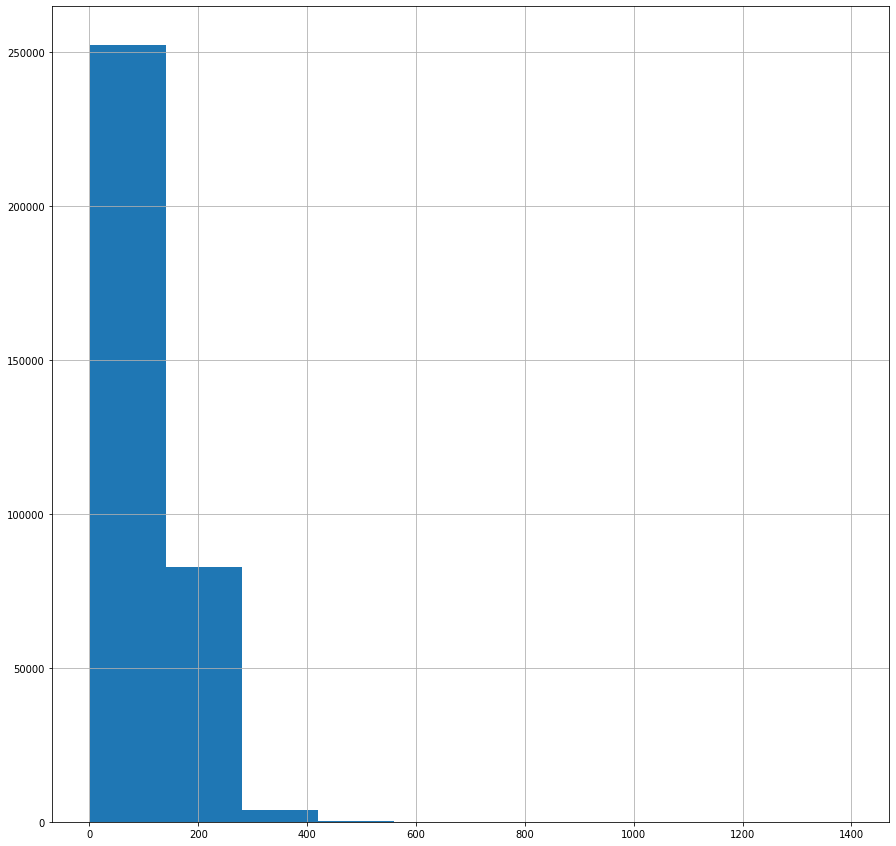

In [28]:
# Проверим на гистограмме как прошла обработка выбросов
processed_data['Power'].hist(figsize=(15, 15))

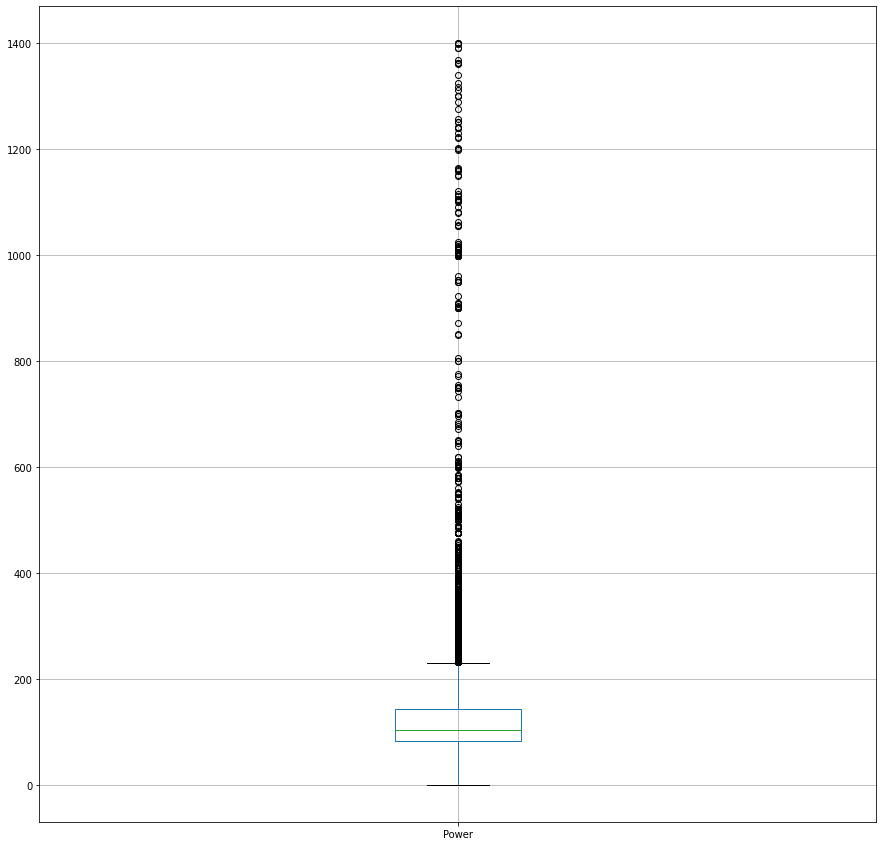

In [29]:
processed_data.boxplot(column='Power', figsize=(15, 15))
plt.show()

Все еще много выбросов, но это могут быть уникальные машины со своими характеристиками. Посмотрим на машины с количеством лошадиных сил больше 400.

In [30]:
processed_data.query('Power > 400')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2781,19500,suv,2004,auto,450,cayenne,125000,petrol,porsche,no
3289,16899,wagon,2003,auto,476,e_klasse,150000,petrol,mercedes_benz,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
4310,2700,sedan,2007,manual,500,5er,100000,NaN,bmw,no
...,...,...,...,...,...,...,...,...,...,...
352322,15999,wagon,2007,auto,435,other,150000,petrol,audi,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN
354045,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
354260,399,other0,1994,manual,1103,3er,150000,NaN,bmw,NaN


485 машин с очень мощными движками, но вот первая же строка вызывает подозрения, что у короллы с кузовом small указан объем двигателя, а не лошадиные силы. Такие ошибки и выбросы могут влиять на модели, уберу все значения, которые превышают 450 лошадиных сил.

In [31]:
processed_data = processed_data.query('Power < 450')

<AxesSubplot: >

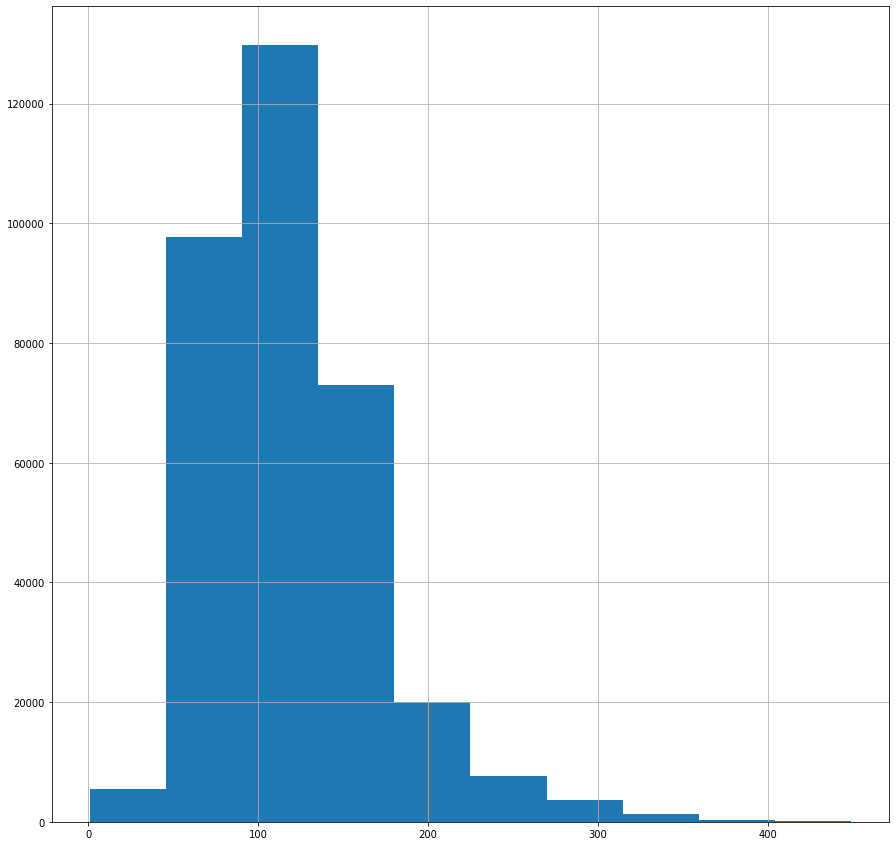

In [32]:
# Проверим на гистограмме как прошла обработка выбросов
processed_data['Power'].hist(figsize=(15, 15))

Теперь на гистограмме также заметны автомобили, мощность которых почти равна нулю, посмотрим на них.

In [33]:
processed_data.query('Power < 25')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
431,3950,small,2004,auto,5,NaN,70000,gasoline,sonstige_autos,no
1235,4450,small,1971,manual,23,500,70000,petrol,fiat,no
3349,1990,small,2004,manual,7,polo,150000,gasoline,volkswagen,no
4637,870,wagon,2000,manual,16,focus,150000,NaN,ford,no
9561,9000,sedan,2009,manual,2,a4,5000,gasoline,audi,NaN
...,...,...,...,...,...,...,...,...,...,...
349666,1500,sedan,2016,manual,2,NaN,150000,gasoline,volkswagen,NaN
350502,6200,small,1964,manual,20,NaN,40000,petrol,sonstige_autos,no
353127,8600,convertible,2012,manual,8,NaN,5000,gasoline,sonstige_autos,no
353447,2900,small,1969,manual,18,500,5000,petrol,fiat,no


Конечно есть такие автомобили как Une Voiture Sans Permis с 5 лошадиными силами, но давайте считать, что меньше 25 лошадиных сил - это уже ошибка, уберем эти значения из дата сета.

In [34]:
processed_data = processed_data.query('Power > 25')

<AxesSubplot: >

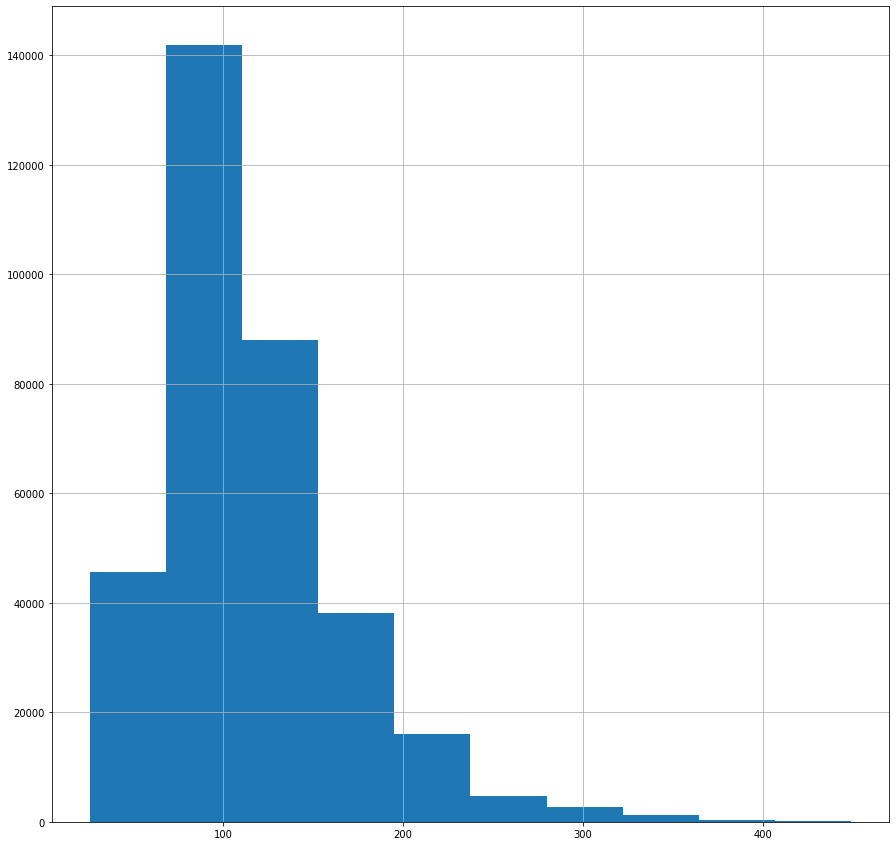

In [35]:
# Проверим на гистограмме как прошла обработка выбросов
processed_data['Power'].hist(figsize=(15, 15))

#### Модель

In [36]:
processed_data['Model'].value_counts()

golf                  27576
other                 23637
3er                   19199
polo                  12429
corsa                 11915
                      ...  
kalina                    6
serie_3                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [37]:
processed_data['Model'].isna().sum()

17247

Самая популярная модель - гольф, но у нас есть 17101 пропуск. Так как следующая популярная модель значится как другое(англ. other), то заменим пропуски на это значение.

In [38]:
# Заменим пропуски в типе модели на 'другое2'
# так как у нас уже есть столбец со значением other и это вызовет ошибку позже.
processed_data['Model'] = processed_data['Model'].fillna('other2')
# Нам также нужно заменить в этом столбце все значение other на other2
processed_data = processed_data.replace({'Model':{'other' : 'other2'}})
# Проверим работу кода
processed_data['Model'].isna().sum()

0

#### Пробег

In [39]:
# Проверим значения в столбце
processed_data['Kilometer'].value_counts()

150000    227094
125000     34977
100000     14352
90000      11160
80000       9730
70000       8329
60000       7248
50000       6021
5000        5730
40000       4768
30000       4254
20000       3741
10000       1093
Name: Kilometer, dtype: int64

In [40]:
processed_data['Kilometer'].describe()

count    338497.000000
mean     128231.343262
std       37714.937796
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [41]:
processed_data['Kilometer'].isna().sum()

0

Пропусков нет, отрицательных значений нет, можно ничего не менять.

#### Тип топлива

In [42]:
# Посмотрим значения в столбце с типом топлива
processed_data['FuelType'].value_counts()

petrol      209241
gasoline     96103
lpg           5148
cng            540
hybrid         224
other          179
electric        51
Name: FuelType, dtype: int64

In [43]:
processed_data['FuelType'].isna().sum()

27011

А вот здесь интересно, обратимся к словарю:

petrol - бензин, топливо, нефть, горючее, статье, бензиновый;\
gasoline - бензин, топливо, горючее, газ, газолин, бензиновый, бензины;\
lpg -  сжиженный газ (пропан-бутан);\
cng - сжатый природный газ (метан);

То есть в таблице отсутствуют дизельные варианты автомобилей, и при этом для бензинового двигателя указаны два синонима. Заменим gasoline на petrol, так как первое значение превалирует.

In [44]:
# Заменим gasoline на petrol

processed_data = processed_data.replace({'FuelType':{'gasoline' : 'petrol'}})
processed_data['FuelType'].value_counts()


petrol      305344
lpg           5148
cng            540
hybrid         224
other          179
electric        51
Name: FuelType, dtype: int64

In [45]:
# Заменим пропуски в типе топлива на 'petrol'.
processed_data['FuelType'] = processed_data['FuelType'].fillna('petrol')
# Проверим работу кода
processed_data['FuelType'].isna().sum()

0

#### Бренд автомобиля

In [46]:
# Посмотрим значения в столбце с брендами
processed_data['Brand'].value_counts()

volkswagen        73054
opel              37903
bmw               35727
mercedes_benz     30895
audi              28373
ford              24114
renault           16865
peugeot           10612
fiat               9028
seat               6516
mazda              5394
skoda              5354
smart              5020
citroen            4889
nissan             4737
toyota             4453
hyundai            3442
volvo              3139
mini               3091
sonstige_autos     2922
mitsubishi         2904
honda              2683
kia                2361
suzuki             2246
alfa_romeo         2229
chevrolet          1692
chrysler           1387
dacia               873
daihatsu            780
subaru              738
porsche             706
jeep                645
trabant             548
land_rover          536
saab                514
daewoo              511
jaguar              497
rover               458
lancia              443
lada                218
Name: Brand, dtype: int64

In [47]:
processed_data['Brand'].isna().sum()

0

Пропусков нет, неявных дубликатов не обнаружено, можно ничего не менять.

#### Факт ремонта

In [48]:
# Посмотрим значения в поле с данными о осуществленном ремонте автомобиля
processed_data['Repaired'].value_counts()

no     239379
yes     34731
Name: Repaired, dtype: int64

In [49]:
processed_data['Repaired'].isna().sum()

64387

64 тысячи пропусков. Порой даже мастер с 20-ним опытом не сможет сразу сказать, был ли автомобиль в ремонте. Мы же их даже не видим, нам не остается ничего другого как заменить пропуски на "неизвестно".

In [50]:
# Заменим пропуски
processed_data['Repaired'] = processed_data['Repaired'].fillna('unknown')

# Проверим работу кода
processed_data['Repaired'].isna().sum()

0

#### Дубликаты

In [93]:
# Удалим дубликаты
processed_data = processed_data.drop_duplicates().reset_index(drop=True)

# Проверим работу кода
processed_data.duplicated().sum()

0

#### Обзор после предобработки данных 

In [52]:
# посмотрим на все данные после обработки
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289330 entries, 0 to 289329
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             289330 non-null  int32 
 1   VehicleType       289330 non-null  object
 2   RegistrationYear  289330 non-null  int64 
 3   Gearbox           289330 non-null  object
 4   Power             289330 non-null  int32 
 5   Model             289330 non-null  object
 6   Kilometer         289330 non-null  int64 
 7   FuelType          289330 non-null  object
 8   Brand             289330 non-null  object
 9   Repaired          289330 non-null  object
dtypes: int32(2), int64(2), object(6)
memory usage: 19.9+ MB


In [53]:
processed_data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

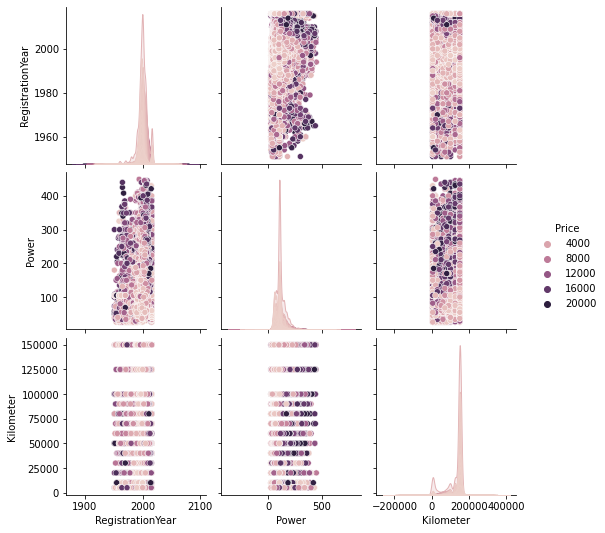

In [54]:
# график взаимосвязи исходных данных с ценой
sns.pairplot(processed_data, hue='Price')

In [55]:
# Проверим какие столбцы влияют на столбец с ценой через корреляцию

phik_overview = processed_data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.00,0.25,0.63,0.31,0.50,0.57,0.31,0.05,0.35,0.36
VehicleType,0.25,1.00,0.18,0.26,0.45,0.90,0.18,0.08,0.61,0.14
RegistrationYear,0.63,0.18,1.00,0.11,0.23,0.62,0.37,0.07,0.40,0.23
Gearbox,0.31,0.26,0.11,1.00,0.55,0.60,0.03,0.10,0.49,0.04
Power,0.50,0.45,0.23,0.55,1.00,0.77,0.10,0.08,0.54,0.19
Model,0.57,0.90,0.62,0.60,0.77,1.00,0.43,0.33,1.00,0.28
Kilometer,0.31,0.18,0.37,0.03,0.10,0.43,1.00,0.07,0.27,0.24
FuelType,0.05,0.08,0.07,0.10,0.08,0.33,0.07,1.00,0.23,0.04
Brand,0.35,0.61,0.40,0.49,0.54,1.00,0.27,0.23,1.00,0.16
Repaired,0.36,0.14,0.23,0.04,0.19,0.28,0.24,0.04,0.16,1.00


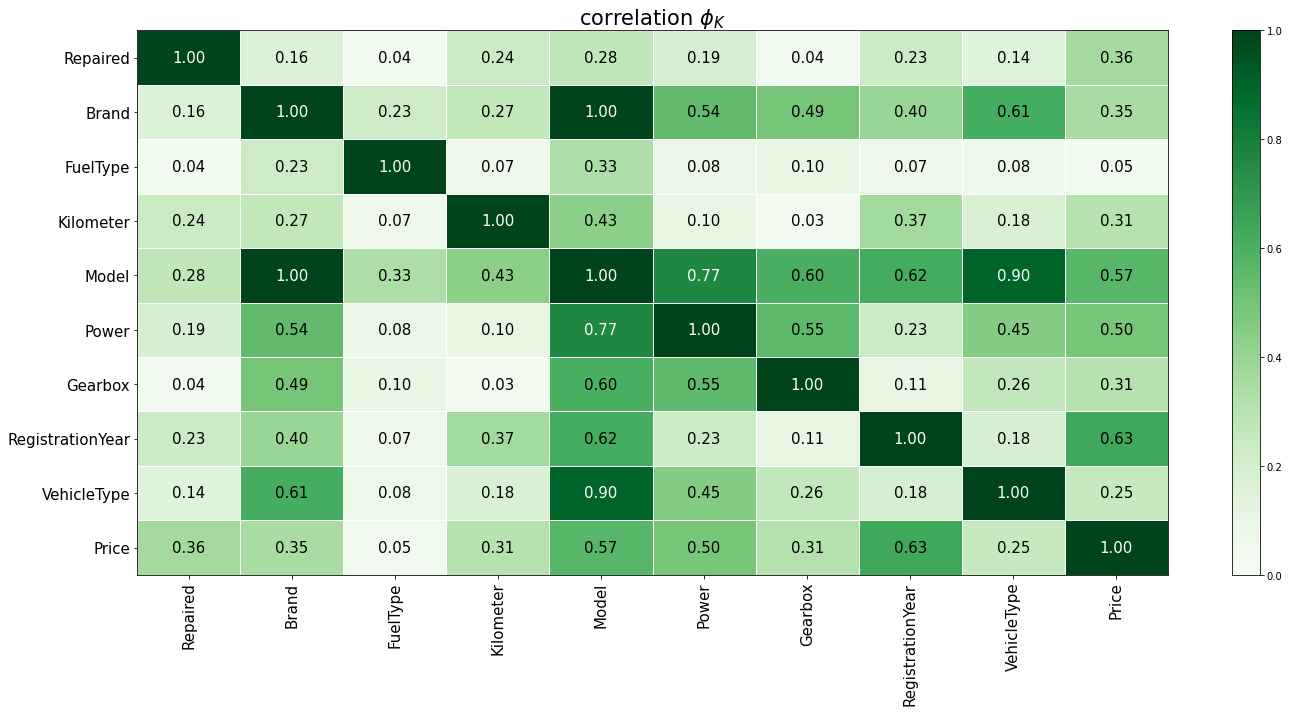

In [56]:
# Создадим тепловую карту на основе библиотеки Phik
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout()

### Вывод по результатам корреляции

Глядя на таблицу и на график, можно заметить, что не все столбцы имеют влияние на цену, подведем итоги для каждого столбца:

Самую высокую корреляцию с целом имеет признак с годом регистрации автомобиля. Также на цену влияют модель и мощность двигателя.

Наличие ремонта, тип коробки передач и тип кузова имеют влияние на цену, но уже не такое высокое.

Меньше всего на цену автомобиля влияет тип топлива, корреляция почти равна нулю.


### Выводы по предобработке полученных данных

- Были удалены столбцы, которые не имеют значения для цены автомобиля,
- Были удалены или изменены выбросы на более логичные значения,
- Были убраны или заменены пропуски,
- Были удалены явные дубликаты и обработаны неявные, как например в столбце с типом топлива,
- Датасет уменьшился в размерах, что ускорит время обработки моделями.

## Обучение моделей

### Выбор моделей

В работе будут использоваться следующие модели:

-	LinearRegression
-	DecisionTreeRegressor
-	XGBoost
-	LGBMRegressor
-	CatBoostRegressor

Первые три модели требуют только цифровых значений, поэтому для них сделаем выборки с One-Hot кодировкой.

Для LightGBM и Категориального бустинга будем использовать данные, полученные после предобработки данных, так как они могут справиться с категориальными значениями.



In [57]:
# Разделим данные на признаки и целевую выборку
features = processed_data.drop(['Price'], axis=1)
target = processed_data['Price']

In [58]:
# Создадим тренировочный и тестовый датасеты
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [59]:
# Проверим результаты

print('Размер тренировочного датасета - {:.0%}'.format(
    features_train.shape[0]/features.shape[0]))
print('Размер тестового датасета - {:.0%}'.format(
    target_test.shape[0]/target.shape[0]))

features_train.shape
features_train.head()

Размер тренировочного датасета - 75%
Размер тестового датасета - 25%


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
153316,sedan,2016,manual,65,corsa,125000,petrol,opel,no
56469,convertible,2006,manual,109,2_reihe,150000,petrol,peugeot,no
206060,small,1995,auto,75,golf,150000,petrol,volkswagen,yes
97049,sedan,2004,auto,218,x_reihe,150000,petrol,bmw,no
175789,sedan,2005,manual,75,colt,90000,petrol,mitsubishi,no


### One_Hot_Encoding

In [60]:
# Сделаем на основе полученных признаков цифровые значения при помощи One-Hot-Encoding
VehicleType_ohe = pd.get_dummies(features_train['VehicleType'])
Gearbox_ohe = pd.get_dummies(features_train['Gearbox'])
Model_ohe = pd.get_dummies(features_train['Model'])
FuelType_ohe = pd.get_dummies(features_train['FuelType'])
Brand_ohe = pd.get_dummies(features_train['Brand'])
Repaired_ohe = pd.get_dummies(features_train['Repaired'])

In [61]:
#уберем первоначальные категориальные признаки
features_train_ohe = features_train.drop(['VehicleType',
                                         'Gearbox',
                                         'Model',
                                         'FuelType',
                                         'Brand',
                                         'Repaired'],
                                          axis=1)

features_train.shape

(216997, 9)

In [62]:
#склеим полученные цифровые поля с OHE датасетом функцией concat
features_train_ohe = pd.concat([features_train_ohe,
VehicleType_ohe,
Gearbox_ohe,
Model_ohe,
FuelType_ohe,
Brand_ohe,
Repaired_ohe,
], axis=1)

features_train_ohe.shape

(216997, 312)

Колонок конечно стало много, зато теперь эти данные можно отдать на обработку моделям.

In [63]:
# Проверим количество строк и столбцов

print('Количество строк и столбцов в исходной выборке:', features_train.shape)
print('Количество строк и столбцов в OHE выборке:', features_train_ohe.shape)
print('Количество строк в целевой выборке:', len(target_train))


Количество строк и столбцов в исходной выборке: (216997, 9)
Количество строк и столбцов в OHE выборке: (216997, 312)
Количество строк в целевой выборке: 216997


### Линейная регрессия

Посмотрим на результаты линейной регрессии для OHE-выборки с использованием кросс-валидации.

In [64]:
%%time
# Инициализация модели линейной регрессии

start = time.time()

lr = LinearRegression()
print('Обучение линейной регрессии для RMSE')
print()
rmse_lr_cv = np.abs((cross_val_score(lr, 
                             features_train_ohe, 
                             target_train, 
                             cv=5, 
                             scoring='neg_root_mean_squared_error').mean()))
print('Среднее значение RMSE на кросс-валидации для линейной регрессии =', rmse_lr_cv)

end = time.time()
lr_train_time = end - start
print('Время обучения модели LR:', lr_train_time)


Обучение линейной регрессии для RMSE

Среднее значение RMSE на кросс-валидации для линейной регрессии = 2816.314207845329
Время обучения модели LR: 15.99627423286438
CPU times: total: 1min 17s
Wall time: 16 s


Цель в RMSE = 2500 так близко, но так далека.

In [66]:
start = time.time()
lr.fit(features_train_ohe, target_train)
lr_predict = lr.predict(features_train_ohe)
end = time.time()
lr_predict_time = end - start
print('Время предсказания модели LR:', lr_predict_time)

Время предсказания модели LR: 4.085077524185181


### Дерево решений

Для дерева решений используем метод GridSearch, который уже имеет встроенную кросс-валидацию.

In [67]:
# Сделаем прямое кодирование

encoder = OrdinalEncoder()
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
cat_features = features_train[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

ordinal_features_train = ordinal_features.loc[features_train.index, :]

In [68]:
%%time
# Инициализация модели дерева решений
start = time.time()

parameters = {'max_depth'    : [4, 6, 8, 10],
              'max_features' : ['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(DecisionTreeRegressor(),parameters, scoring='neg_root_mean_squared_error')
model_dt = grid.fit(ordinal_features_train, target_train)
best_dt = np.abs(model_dt.best_score_)
best_model_dt = model_dt.best_params_
print(model_dt.best_params_,'\n')
print('Лучший показатель RMSE:', best_dt)

end = time.time()
dt_train_time = end - start
print('Время обучения модели DT:', dt_train_time)

{'max_depth': 10, 'max_features': 'auto'} 

Лучший показатель RMSE: 2103.8840230856686
Время обучения модели DT: 6.8397204875946045
CPU times: total: 6.83 s
Wall time: 6.84 s


In [69]:
start = time.time()
model_dt.fit(ordinal_features_train, target_train)
dt_predict = model_dt.predict(ordinal_features_train)
end = time.time()
dt_predict_time = end - start
print('Время предсказания модели DT:', dt_predict_time)

Время предсказания модели DT: 6.8905792236328125


Модель дерева выдала на тренировочной модели значение ниже требуется 2500.

### XGBoost

In [70]:
%%time
start = time.time()
gsc = GridSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],},
            cv=3, scoring='neg_root_mean_squared_error', verbose=0, n_jobs=-1, error_score='raise')

model_xgb = gsc.fit(ordinal_features_train, target_train)
best_model_xgb = model_xgb.best_params_

best_xgb = np.abs(model_xgb.best_score_)
print(model_xgb.best_params_,'\n')
print('Лучший показатель RMSE:', best_xgb)

end = time.time()
xgb_train_time = end - start
print('Время обучения модели XGBoost:', xgb_train_time)

{'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 5} 

Лучший показатель RMSE: 1773.4624284226422
Время обучения модели XGBoost: 517.9016427993774
CPU times: total: 38.4 s
Wall time: 8min 37s


In [71]:
start = time.time()
model_xgb.fit(ordinal_features_train, target_train)
xgb_predict = model_xgb.predict(ordinal_features_train)
end = time.time()
xgb_predict_time = end - start
print('Время предсказания модели XGBoost:', xgb_predict_time)

Время предсказания модели XGBoost: 520.2051427364349


XGBoost выдал показатель RMSE со значением 1754, отличный результат!

Для моделей CatBoost и LightGBM будем использовать исходные данные, так как они должны уметь работать с категориальными признаками.

### CatBoost

In [72]:
%%time
start = time.time()

parameters = {'depth'         : [6, 8, 10],
            'learning_rate'   : [0.01, 0.05, 0.1],
            'iterations'      : [30, 50, 100]
            }

cbr = CatBoostRegressor()

grid = GridSearchCV(estimator=cbr, param_grid = parameters,
                    cv = 2, n_jobs=-1, scoring='neg_root_mean_squared_error')
                    
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

model_cbr = grid.fit(features_train, target_train, cat_features=cat_features, verbose=10)
best_model_cbr = model_cbr.best_params_

best_cbr = np.abs(model_cbr.best_score_)
print(model_cbr.best_params_,'\n')
print('Лучший показатель RMSE:', best_cbr)

end = time.time()
cbr_train_time = end - start
print('Время обучения модели CatBoost:', cbr_train_time)


0:	learn: 4245.0075256	total: 211ms	remaining: 20.9s
10:	learn: 2586.9887600	total: 871ms	remaining: 7.05s
20:	learn: 2098.7304673	total: 1.51s	remaining: 5.69s
30:	learn: 1945.6324472	total: 2.16s	remaining: 4.81s
40:	learn: 1886.5775529	total: 2.81s	remaining: 4.04s
50:	learn: 1853.4239907	total: 3.46s	remaining: 3.32s
60:	learn: 1827.5845302	total: 4.11s	remaining: 2.63s
70:	learn: 1804.3168631	total: 4.76s	remaining: 1.94s
80:	learn: 1784.9496248	total: 5.41s	remaining: 1.27s
90:	learn: 1768.4302187	total: 6.06s	remaining: 599ms
99:	learn: 1757.5284902	total: 6.65s	remaining: 0us
{'depth': 10, 'iterations': 100, 'learning_rate': 0.1} 

Лучший показатель RMSE: 1822.1130106168382
Время обучения модели CatBoost: 65.26654958724976
CPU times: total: 36.4 s
Wall time: 1min 5s


In [73]:
start = time.time()
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
model_cbr.fit(features_train, target_train, cat_features=cat_features, verbose=10)
cbr_predict = model_cbr.predict(features_train)
end = time.time()
cbr_predict_time = end - start
print('Время предсказания модели CatBoost:', cbr_predict_time)

0:	learn: 4245.0075256	total: 65.8ms	remaining: 6.52s
10:	learn: 2586.9887600	total: 727ms	remaining: 5.88s
20:	learn: 2098.7304673	total: 1.37s	remaining: 5.15s
30:	learn: 1945.6324472	total: 2.01s	remaining: 4.47s
40:	learn: 1886.5775529	total: 2.64s	remaining: 3.8s
50:	learn: 1853.4239907	total: 3.29s	remaining: 3.16s
60:	learn: 1827.5845302	total: 3.93s	remaining: 2.51s
70:	learn: 1804.3168631	total: 4.57s	remaining: 1.86s
80:	learn: 1784.9496248	total: 5.21s	remaining: 1.22s
90:	learn: 1768.4302187	total: 5.84s	remaining: 578ms
99:	learn: 1757.5284902	total: 6.42s	remaining: 0us
Время предсказания модели CatBoost: 61.67974376678467


RMSE равен 1822 для категориального бустинга, очень неплохой результат.

### LightGBM

In [74]:
%%time
start = time.time()

param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

# Переведем категориальные признаки из типа в object в тип category, чтобы LGBMRegressor мог с ними работать


features_train['VehicleType'] = features_train['VehicleType'].astype('category')
features_train['Gearbox'] = features_train['Gearbox'].astype('category')
features_train['Model'] = features_train['Model'].astype('category')
features_train['FuelType'] = features_train['FuelType'].astype('category')
features_train['Brand'] = features_train['Brand'].astype('category')
features_train['Repaired'] = features_train['Repaired'].astype('category')

lgbm = LGBMRegressor()

grid = GridSearchCV(estimator=lgbm, param_grid = param_grid,
                    cv = 2, n_jobs=-1, scoring='neg_root_mean_squared_error', error_score='raise')
                    

model_lgbm = grid.fit(features_train, target_train)
best_model_lgbm = model_lgbm.best_params_

best_lgbm = np.abs(model_lgbm.best_score_)
print(model_lgbm.best_params_,'\n')
print('Лучший показатель RMSE:', best_lgbm)

end = time.time()
lgbm_train_time = end - start
print('Время обучения модели LightGBM:', lgbm_train_time)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
{'lambda_l1': 1, 'lambda_l2': 0, 'min_data_in_leaf': 50, 'num_leaves': 127, 'reg_alpha': 0.1} 

Лучший показатель RMSE: 1716.7441296434495
Время обучения модели LightGBM: 76.59580755233765
CPU times: total: 11.9 s
Wall time: 1min 16s


In [75]:
start = time.time()
model_lgbm.fit(features_train, target_train)
cbr_predict = model_lgbm.predict(features_train)
end = time.time()
lgbm_predict_time = end - start
print('Время предсказания модели LightGBM:', lgbm_predict_time)

Время предсказания модели LightGBM: 76.81420063972473


RMSE для LGBMRegressor равен 1716, самый лучший результат!

## Анализ моделей

Подведем итоги по полученным RMSE на моделях для тренировочных выборок. Для этого создадим таблицу с результатами.

Во все модели были добавлены формулы для расчета времени на тренировочной модели и на предсказании. Эти результаты также были выведены в общей таблице.

In [76]:
index = ['LinearRegression',
         'DecisionTreeRegressor',
         'XGBRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']
data = {'RMSE на кросс-валидации':[rmse_lr_cv,
                            best_dt,
                            best_xgb,
                            best_cbr,
                            best_lgbm],
        'Время обучения на CV, сек':[lr_train_time,
                                     dt_train_time,
                                     xgb_train_time,
                                     cbr_train_time,
                                     lgbm_train_time],
        'Время предсказания модели, сек':[lr_predict_time,
                                          dt_predict_time,
                                          xgb_predict_time,
                                          cbr_predict_time,
                                          lgbm_predict_time],        
        'Лучшие гиперпараметры для GreadSearch':    ['-',
                                     model_dt.best_params_,
                                     model_xgb.best_params_,
                                     model_cbr.best_params_,
                                     model_lgbm.best_params_],
}

scores_data = pd.DataFrame(data=data, index=index)
pd.set_option('display.max_colwidth', -1),
scores_data

,RMSE на кросс-валидации,"Время обучения на CV, сек","Время предсказания модели, сек",Лучшие гиперпараметры для GreadSearch
LinearRegression,2816.314208,15.996274,4.085078,-
DecisionTreeRegressor,2103.884023,6.839720,6.890579,"{'max_depth': 10, 'max_features': 'auto'}"
XGBRegressor,1773.462428,517.901643,520.205143,"{'colsample_bytree': 0.4, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 8, 'min_child_weight': 5}"
CatBoostRegressor,1822.113011,65.266550,61.679744,"{'depth': 10, 'iterations': 100, 'learning_rate': 0.1}"
LGBMRegressor,1716.744130,76.595808,76.814201,"{'lambda_l1': 1, 'lambda_l2': 0, 'min_data_in_leaf': 50, 'num_leaves': 127, 'reg_alpha': 0.1}"


### Время предсказания моделей без подбора гиперпараметров

#### Линейная регрессия

In [77]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)

CPU times: total: 19.8 s
Wall time: 3.78 s


LinearRegression()

In [78]:
%%time

lr_target_prediction = model_lr.predict(features_train_ohe)
rmse_lr = mean_squared_error(target_train, lr_target_prediction) ** 0.5

CPU times: total: 500 ms
Wall time: 331 ms


#### Дерево решений

In [79]:
%%time

model_dt = DecisionTreeRegressor()
model_dt.fit(ordinal_features_train, target_train)

CPU times: total: 609 ms
Wall time: 599 ms


DecisionTreeRegressor()

In [80]:
%%time

dt_target_prediction = model_dt.predict(ordinal_features_train)
rmse_dt = mean_squared_error(target_train, lr_target_prediction) ** 0.5

CPU times: total: 78.1 ms
Wall time: 80.8 ms


#### XGBRegressor

In [81]:
%%time

model_xgb = xgb.XGBRegressor()
model_xgb.fit(ordinal_features_train, target_train)

CPU times: total: 23.4 s
Wall time: 2.12 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [82]:
%%time

xgb_target_prediction = model_xgb.predict(ordinal_features_train)
rmse_xgb = mean_squared_error(target_train, xgb_target_prediction) ** 0.5

CPU times: total: 859 ms
Wall time: 77.7 ms


#### CatBoost

In [83]:
%%time

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

model_cbr = CatBoostRegressor()
model_cbr.fit(features_train, target_train, cat_features=cat_features, verbose=10)


Learning rate set to 0.095794
0:	learn: 4282.5017882	total: 80.5ms	remaining: 1m 20s
10:	learn: 2766.1361124	total: 794ms	remaining: 1m 11s
20:	learn: 2263.5975252	total: 1.51s	remaining: 1m 10s
30:	learn: 2089.1143696	total: 2.15s	remaining: 1m 7s
40:	learn: 2012.3800732	total: 2.82s	remaining: 1m 5s
50:	learn: 1968.2619390	total: 3.46s	remaining: 1m 4s
60:	learn: 1938.4265494	total: 4.15s	remaining: 1m 3s
70:	learn: 1916.7250269	total: 4.83s	remaining: 1m 3s
80:	learn: 1900.0028570	total: 5.49s	remaining: 1m 2s
90:	learn: 1885.6686493	total: 6.14s	remaining: 1m 1s
100:	learn: 1873.3729938	total: 6.78s	remaining: 1m
110:	learn: 1861.5641723	total: 7.42s	remaining: 59.4s
120:	learn: 1850.8503483	total: 8.08s	remaining: 58.7s
130:	learn: 1841.4463053	total: 8.73s	remaining: 57.9s
140:	learn: 1833.1525610	total: 9.46s	remaining: 57.6s
150:	learn: 1825.9744059	total: 10.2s	remaining: 57.2s
160:	learn: 1819.4798885	total: 10.8s	remaining: 56.5s
170:	learn: 1813.5082368	total: 11.5s	remaini

In [84]:
%%time

cbr_target_prediction = model_cbr.predict(features_train)
rmse_xgb = mean_squared_error(target_train, cbr_target_prediction) ** 0.5

CPU times: total: 2.23 s
Wall time: 277 ms


#### LightGBM

In [85]:
%%time

features_train['VehicleType'] = features_train['VehicleType'].astype('category')
features_train['Gearbox'] = features_train['Gearbox'].astype('category')
features_train['Model'] = features_train['Model'].astype('category')
features_train['FuelType'] = features_train['FuelType'].astype('category')
features_train['Brand'] = features_train['Brand'].astype('category')
features_train['Repaired'] = features_train['Repaired'].astype('category')

model_lgbm = LGBMRegressor()
model_lgbm.fit(features_train, target_train)

CPU times: total: 3.34 s
Wall time: 353 ms


LGBMRegressor()

In [86]:
%%time

lgbm_target_prediction = model_lgbm.predict(features_train)
rmse_lgbm = mean_squared_error(target_train, lgbm_target_prediction) ** 0.5

CPU times: total: 2 s
Wall time: 179 ms


### LGBM для тестовой модели

In [87]:
%%time
#Инициализация LGBM регрессора для тестовой выборки

features_test['VehicleType'] = features_test['VehicleType'].astype('category')
features_test['Gearbox'] = features_test['Gearbox'].astype('category')
features_test['Model'] = features_test['Model'].astype('category')
features_test['FuelType'] = features_test['FuelType'].astype('category')
features_test['Brand'] = features_test['Brand'].astype('category')
features_test['Repaired'] = features_test['Repaired'].astype('category')

lgbm_test_model = LGBMRegressor(lambda_l1=1, lambda_l2 = 0, min_data_in_leaf = 50, num_leaves = 127, reg_alpha = 0.1, random_state=RANDOM_STATE)
lgbm_test_model.fit(features_train, target_train)
lgbm_test_predictions = lgbm_test_model.predict(features_test)

final_lgbm_test_RMSE = mean_squared_error(target_test, lgbm_test_predictions) ** 0.5
print('RMSE для LGBM:', final_lgbm_test_RMSE)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
RMSE для LGBM: 1691.2117488396273
CPU times: total: 8 s
Wall time: 767 ms


Требуемое значение RMSE достигнуто на модели LGBM регрессии

### CatBoost для тестовой модели

In [88]:
%%time
#Инициализация категориального бустинга для тестовой выборки

# Для работы с категориальным бустингом придется вернуть формат object для категориальных признаков

features_train['VehicleType'] = features_train['VehicleType'].astype('object')
features_train['Gearbox'] = features_train['Gearbox'].astype('object')
features_train['Model'] = features_train['Model'].astype('object')
features_train['FuelType'] = features_train['FuelType'].astype('object')
features_train['Brand'] = features_train['Brand'].astype('object')
features_train['Repaired'] = features_train['Repaired'].astype('object')

features_test['VehicleType'] = features_test['VehicleType'].astype('object')
features_test['Gearbox'] = features_test['Gearbox'].astype('object')
features_test['Model'] = features_test['Model'].astype('object')
features_test['FuelType'] = features_test['FuelType'].astype('object')
features_test['Brand'] = features_test['Brand'].astype('object')
features_test['Repaired'] = features_test['Repaired'].astype('object')

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

cbr_test_model = CatBoostRegressor(max_depth=10, iterations = 100, learning_rate = 0.1, random_state=RANDOM_STATE)
cbr_test_model.fit(features_train, target_train, cat_features=cat_features, verbose=10)
cbr_test_predictions = cbr_test_model.predict(features_test)

final_cbr_test_RMSE = mean_squared_error(target_test, cbr_test_predictions) ** 0.5
print('RMSE для CatBoost:', final_cbr_test_RMSE)

0:	learn: 4245.0075256	total: 67.8ms	remaining: 6.71s
10:	learn: 2586.9887600	total: 724ms	remaining: 5.86s
20:	learn: 2098.7304673	total: 1.38s	remaining: 5.18s
30:	learn: 1945.6324472	total: 2.03s	remaining: 4.53s
40:	learn: 1886.5775529	total: 2.68s	remaining: 3.86s
50:	learn: 1853.4239907	total: 3.33s	remaining: 3.2s
60:	learn: 1827.5845302	total: 3.97s	remaining: 2.54s
70:	learn: 1804.3168631	total: 4.62s	remaining: 1.89s
80:	learn: 1784.9496248	total: 5.26s	remaining: 1.23s
90:	learn: 1768.4302187	total: 5.91s	remaining: 584ms
99:	learn: 1757.5284902	total: 6.5s	remaining: 0us
RMSE для CatBoost: 1801.2645254399515
CPU times: total: 34.3 s
Wall time: 7.19 s


Требуемое значение RMSE было также достигнуто на модели Категориального бустинга.

### Общий вывод

1) Данные были загружены и обработаны:
    - обработка пропусков,
    - удаление дубликатов,
    - слияние неявных дубликатов
2) Для работы с определенными моделями были созданы выборки с OHE обработкой.
3) Все модели были запущены и получены результаты RMSE.
4) Лучшие показатели по времени исполнения и по показателю RMSE были получены для модели LGBM. Но модель имеет чувствительность к формату данных, она может работать с категориальными признаками, но их необходимо переводить в формат "catagory", что может вызывать определенные неудобства.
5) Модель категориального бустинга CatBoost также показала хороший результат для RMSE, но он немного выше чем у LGBM, и при этом время исполнения гораздо выше. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей